# Data Import and Consolidation {-}

In [9]:
!pip install pandas_datareader
!pip install quandl
!pip install wrds
!pip install statsmodels

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 64.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.8/233.8 KB 44.1 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# after we install all the packages, import all of them for the use in today's lecture!
import platform
my_system = platform.uname()
print(f'My PC node: {my_system.node.lower()}')
import time
import tqdm 
from tqdm import tqdm 
tqdm.pandas(desc='My bar!')

# database access
import pandas_datareader as web
import quandl as quandl
import wrds as wrds


# storage and operations
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
import joblib

# Visualization Libraries 
import matplotlib.pyplot as plt 

# Statistical Analysis Libraries 
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MaxAbsScaler, PowerTransformer, MinMaxScaler, QuantileTransformer, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
from sklearn.base import BaseEstimator, TransformerMixin # How to create our own scaler 
import statsmodels.api as sm
import linearmodels as lm 

# Others 
from joblib import Parallel, delayed
from multiprocessing import Pool, cpu_count
if cpu_count() > 8:
    print(cpu_count())
else:
    CPUUsed = cpu_count()
    
plt.rcParams.update({'font.size':20})

import statsmodels.api as sm

import warnings 
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_columns', None)



# after we install all the packages, import all of them for the use in today's lecture!
from __future__ import print_function

--- 
### Overview of data: 

1. The list of stocks in terms of PERMNO -- the same list as for Homework 2/ available on Dropbox

2. The data on factors is available at the Ken French web-site [use the 4-factor model]


3. WRDS data on stock returns [CRSP], options [OptionMetrics], fundamentals [COMPUSTAT]

4. Factor Betas Calculation 


5. Selected ready-to-use option-implied data available on https://osf.io/z2486/, specifically, you can use  Generalized lower bounds https://osf.io/7xcqwLinks to an external site. from https://dx.doi.org/10.2139/ssrn.3565130

6. Risk-neutral skewness https://osf.io/btvdh/ from http://dx.doi.org/10.2139/ssrn.1301648 

7. Any other features you might find useful (technical analysis, sentiment, price patterns, etc.)


---

###  Data Retrieval 


In [ ]:
class FileNames:
    fn_csv_factors   = 'data/ff_fact.csv'
    fn_excel_factors = 'data/ff_fact.xls'

    fn_crsp     = 'data/crsp.h5'
    key_crsp_daily = 'daily'

    fn_stock_features_labels = 'data/stock_features.h5'
    key_features_crsp = 'crsp'

    fn_stock_features_om = 'data/stock_features_om.h5'
    key_features_om = 'om'

    fn_ff_factors    = 'data/ff_factors.h5'
    key_ff_daily    = 'ff_daily'

    fn_sp500comp     = 'data/SP500_Index_Constitutes2020.csv'
    fn_id_link =  'data/daily_permno_secid_cusip_link.csv'
    fn_universe = 'data/permno_selection.csv'
    
    # Additional features for project 
    gen_lower_bounds = 'data/glb_daily.csv'
    risk_neutral_skewness = 'data/mfis.csv'

In [4]:
db = wrds.Connection() 
db.create_pgpass_file()

# diegozu97
# Password1997!

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


--- 
### 1. The list of stocks in terms of PERMNO {-}

In [5]:
permno_selection = pd.read_csv(FileNames.fn_universe)
permno_selection_list = list(permno_selection["permno"])
len(permno_selection_list)

50

----
### 2. The data on factors is available at the Ken French web-site [use the 4-factor model] {-}

Factor Model (Daily) from Ken French data library - Importing the dataset of famfrench since 1999

In [6]:
startdt = datetime.datetime(1999, 1, 1)

d1 = web.DataReader('F-F_Research_Data_Factors_daily','famafrench',start = startdt)
d2 = web.DataReader('F-F_Momentum_Factor_daily','famafrench',start = startdt)

ff = d1[0]/100
ff = ff.join(d2[0]/100, how = 'left') # Joining 3-factor model with momentum

ff.columns = [z.lower().strip() for z in ff.columns]
ff.rename(columns = {'mkt-rf':'mktrf'}, inplace = True)

ff = ff.loc[:,['mktrf', 'smb', 'hml', 'mom','rf']]
ff.index.names = ['date']
ff.head()

,mktrf,smb,hml,mom,rf
date,,,,,
1999-01-04,-0.0019,0.0014,0.0041,-0.0149,0.00019
1999-01-05,0.0110,-0.0073,-0.0009,-0.0097,0.00019
1999-01-06,0.0210,-0.0060,-0.0060,-0.0117,0.00019
1999-01-07,-0.0007,0.0049,-0.0029,-0.0072,0.00019
1999-01-08,0.0045,0.0006,0.0028,-0.0016,0.00019


---
### 3. WRDS data on stock returns [CRSP], options [OptionMetrics], fundamentals [COMPUSTAT] from 01/1999  {-}

 #### 3.1 Daily Stock returns, market capitalization (computed as SHROUT*PRICE) (CRSP) 

In [7]:
# load the returns, shares outstanding, and prices for SP500 companies (from 1999)

sql_query = """
select distinct date, permno, cusip, ret, abs(prc) as prc, shrout/1000 as shrout, abs(prc)*shrout/1000 as mktcap
from crsp.dsf
where permno in %(PERMNO)s and EXTRACT(YEAR FROM date)>%(YR)s
"""

# specify the param dictionary with permno
param = {'PERMNO': tuple(permno_selection_list), 'YR': 1998}

# get the data!
crsp_sp500 = db.raw_sql(sql_query, params = param)
crsp_sp500['date'] = pd.to_datetime(crsp_sp500['date'])

In [8]:
print(crsp_sp500.permno.nunique())
crsp_sp500.head()

50


,date,permno,cusip,ret,prc,shrout,mktcap
0,2022-12-23,80539.0,64026810,-0.065217,2.150000,187.954,404.101118
1,2003-08-14,53065.0,46069010,0.014959,13.570000,389.640,5287.414681
2,2002-06-26,46578.0,18905410,-0.001683,41.529999,230.347,9566.310629
3,2016-04-26,53613.0,59511210,0.090995,11.510000,1037.043,11936.365167
4,2016-04-27,52476.0,29442910,0.012203,118.610001,118.983,14112.573703


---
#### 3.2 Options [OptionMetrics]

OptionMetrics data includes information about the implied volatility of options, which is used in options pricing models. We specifically retrieve the implied volatility of at-the-money (ATM) call options and out-of-the-money (OTM) put and call options, as well as the skew between the implied volatility of ATM calls and OTM puts.


In [9]:

def prepare_save_om(load_om_data = True, om_from = 1999, om_to = 2022, restrict_universe = True):
    
    UNIVERSE_PERMNO = ''
    UNIVERSE_SECID = ''
    
    # read link in any case -- need later for merging 
    id_link = pd.read_csv(FileNames.fn_id_link)
    id_link['date']  = pd.to_datetime(id_link['date'])
  
    if restrict_universe:
        # read the sp500 composition and make the string from PERMNO for SQL
        comp = pd.read_csv(FileNames.fn_sp500comp)
        comp['start']  = pd.to_datetime(comp['start']) # transforming the call into datetime format 
        comp['ending'] = pd.to_datetime(comp['ending']) # transforming the call into datetime format 
        comp = comp.loc[comp.ending >= '1999'] # only get those that ended after 1999 
        universe_permno = tuple(comp.permno)
        UNIVERSE_PERMNO = f'AND a.permno in {universe_permno}'

        goods = id_link.permno.isin(permno_selection_list)
        universe_secid = tuple(id_link.loc[goods,'secid'].dropna().unique())
        
        UNIVERSE_SECID = f'AND secid in {universe_secid}'
        pass
    
    if load_om_data:
        
        start = time.time()
        
        data_om = pd.DataFrame()
        for YR in tqdm(range(om_from, om_to+1)):
            sql_wrds = f'''
            
            select a.date, a.secid,
            a.av_atmcall as av_atmcall,
            b.av_otmput as av_otmput,
            c.av_otmcall as av_otmcall,
            b.av_otmput - a.av_atmcall as skew from

            (select date, secid, AVG(impl_volatility) as av_atmcall
            from optionm.vsurfd{YR}
            where days = 30 and delta = 50
            {UNIVERSE_SECID}
            group by date, secid) as a,

            (select date, secid, AVG(impl_volatility) as av_otmput
            from optionm.vsurfd{YR}
            where days = 30 and delta = -10
            {UNIVERSE_SECID}
            group by date, secid) as b,

            (select date, secid, AVG(impl_volatility) as av_otmcall
            from optionm.vsurfd{YR}
            where days = 30 and delta = 10
            {UNIVERSE_SECID}
            group by date, secid) as c

            where a.date = b.date and a.secid = b.secid
            and a.date = c.date and a.secid = c.secid
            '''
            
            try:
                data_om = pd.concat([data_om, db.raw_sql(sql_wrds)], axis = 0)
                # print(f'Finished downloading OM {YR} in {(time.time()-start)/60:.2f} minutes.')
                pass
            except Exception as E: 
                print(E)
            
        db.close()
        data_om.loc[:, 'date'] = pd.to_datetime(data_om.loc[:, 'date'])
        
        # merge with PERMNO to have the same identified as in the other tables
        data_om = data_om.merge(id_link[['date','permno','secid']], how = 'left', on = ['date','secid'])
        print(f'OptionMetrics data saved.')

    return data_om


In [10]:
option_metrics_data = prepare_save_om()

100%|██████████| 24/24 [01:29<00:00,  3.71s/it]


(psycopg2.errors.UndefinedTable) relation "optionm.vsurfd2022" does not exist
LINE 10:             from optionm.vsurfd2022
                          ^

[SQL: 
            
            select a.date, a.secid,
            a.av_atmcall as av_atmcall,
            b.av_otmput as av_otmput,
            c.av_otmcall as av_otmcall,
            b.av_otmput - a.av_atmcall as skew from

            (select date, secid, AVG(impl_volatility) as av_atmcall
            from optionm.vsurfd2022
            where days = 30 and delta = 50
            AND secid in (102386.0, 103125.0, 103355.0, 110169.0, 108893.0, 105340.0, 105696.0, 105174.0, 106689.0, 109224.0, 110337.0, 103157.0, 100972.0, 108130.0, 104508.0, 106566.0, 107430.0, 104361.0, 101368.0, 104560.0, 102660.0, 106638.0, 103979.0, 108910.0, 107318.0, 101281.0, 103106.0, 108117.0, 102548.0, 106808.0, 110952.0, 104411.0, 106329.0, 107544.0, 103313.0, 101121.0, 103912.0, 107704.0, 102021.0, 107078.0, 103980.0, 111337.0, 110513.0, 106125.0, 108055.0

In [11]:
print(option_metrics_data.dtypes)
option_metrics_data.shape

date          datetime64[ns]
secid                float64
av_atmcall           float64
av_otmput            float64
av_otmcall           float64
skew                 float64
permno               float64
dtype: object


(289391, 7)

In [231]:
option_metrics_data.head()

,date,secid,av_atmcall,av_otmput,av_otmcall,skew,permno
0,1999-01-04,100972.0,0.291276,0.452132,0.315215,0.160856,20482.0
1,1999-01-04,101121.0,0.766592,0.823334,0.789454,0.056742,61241.0
2,1999-01-04,101281.0,0.689638,0.809718,0.671771,0.120080,45911.0
3,1999-01-04,101368.0,0.187012,0.288071,0.234582,0.101059,24109.0
4,1999-01-04,102021.0,0.569465,0.552073,0.542057,-0.017392,71298.0


---
### 4 Beta Factor Calculation 

#### Defininng the function get beta by permno





1. The below code defines a function that takes in a dataframe containing stock returns and other financial data, finally it returns the rolling betas of a specific stock determined by "permno".
2. A linear regression calculates the betas with a rolling window of 252. 
3. The factor model to use is ff4. 


In [232]:


def get_beta_bypermno(df, permno = None, window = 252, min_n = int(252/2), factor_model = 'ff4'):

    if (permno is not None) and (permno in df.columns): 
        df = df.rename(columns={permno: 'ret'})
    else:
        print(f'permno {permno} not in the data')

    if factor_model == 'capm':
        formula = f'ret ~ 1 +  mktrf'
    elif factor_model == 'ff3':
        formula = f'ret ~ 1 +  mktrf + smb + hml'
    elif factor_model == 'ff4':
        formula = f'ret ~ 1 +  mktrf + smb + hml + mom'
    elif factor_model == 'ff5':
        formula = f'ret ~ 1 +  mktrf + smb + hml + rmw + cma'
    else:
        formula = f'ret ~ 1'
        pass

    try:
        rres = RollingOLS.from_formula(formula, 
                                       data=df, 
                                       window=window, 
                                       min_nobs=min_n,
                                       missing='drop').fit(params_only=False)
        temp_beta = rres.params.iloc[:,1:]
        temp_beta.columns = [f'beta_{z}' for z in temp_beta.columns]
        temp_beta = temp_beta.join((rres.mse_resid.to_frame(f'idvar_{factor_model}')*252))
        temp_beta['permno'] = permno
        temp_beta = temp_beta.dropna(axis=1, how ='all')
        return temp_beta.reset_index()
    except:
        pass
    pass



In [233]:
def compute_features_labels(data, 
                            ff,
                            factor_model = 'ff4'):

    
    cols2use = ['permno','date','ret','mktcap']
    data0 = data.reset_index()[cols2use].copy()
    data0.sort_values(by = ['permno','date'], inplace = True)


    data0['lret'] = np.log(1+data0['ret'])
    
    #
    # momentum/ reversal can be defined in a number of ways, 
    #e.g. momentum = total return from months - 13 to -1:
    fn_mom12m = lambda x: np.exp(x.rolling(window=252, min_periods=63).sum())-1 
    #e.g. momentum = total return from months - 7 to -1:
    fn_mom6m = lambda x: np.exp(x.rolling(window=126, min_periods=31).sum())-1
    #e.g. reversal = total return for past month:
    fn_rev = lambda x: np.exp(x.rolling(window=21, min_periods=15).sum())-1


    data0['mom12m'] = data0.\
                        groupby(by=['permno'], group_keys=True)['lret'].\
                        apply(fn_mom12m).shift(22).values

    data0['mom6m'] = data0.\
                        groupby(by=['permno'], group_keys=True)['lret'].\
                        apply(fn_mom6m).shift(22).values

    data0['rev1m'] = data0.\
                        groupby(by=['permno'], group_keys=True)['lret'].\
                        apply(fn_rev).values
    
    data0 = data0.drop(columns = ['lret'])
    
    # factor betas 
    # create a slimmer copy for work 
    cols2use = ['permno','date','ret']
    data1 = data0[cols2use].copy().set_index(['date','permno']).sort_index()

    df_ret = data1['ret'].unstack()
    universe = list(df_ret.columns)

    # subtract risk-free rate from returns to get excess returns 
    idx = df_ret.index
    df_ret = df_ret.subtract(ff.loc[idx,'rf'], axis=0)

    # merge to include factors 
    factors = ['mktrf','smb','hml','mom']
    df_ret = df_ret.merge(ff.loc[idx,factors], on = 'date')
    
    with Parallel(n_jobs=-1) as parallel:
        res = parallel(delayed(get_beta_bypermno)(df_ret[[permno, *factors]],
                                          permno,
                                          window = 252,
                                          min_n = 126,
                                          factor_model = factor_model) for permno in universe)
        pass
    
    temp = pd.concat(res)
    temp = temp.set_index(['permno','date']).sort_index().dropna()
    

    data0 = data0.set_index(['permno','date'])
    
    data0 = data0.merge(temp, on = ['permno','date'])


    return data0

In [234]:
crsp_sp500_betas_merged = compute_features_labels(crsp_sp500, ff)
crsp_sp500_betas_merged = crsp_sp500_betas_merged.reset_index()

In [235]:
crsp_sp500_betas_merged.head()

,permno,date,ret,mktcap,mom12m,mom6m,rev1m,beta_mktrf,beta_smb,beta_hml,beta_mom,idvar_ff4
0,10874.0,1999-12-31,-0.011111,2043.150750,-0.099618,-0.057281,0.031884,0.998254,0.764682,0.404181,-0.673465,0.149743
1,10874.0,2000-01-03,-0.014045,2014.454812,-0.109937,-0.080380,0.014451,1.032156,0.784538,0.414427,-0.746982,0.146484
2,10874.0,2000-01-04,-0.045584,1922.627812,-0.107357,-0.099108,-0.026163,1.079493,0.830231,0.437168,-0.727018,0.147118
3,10874.0,2000-01-05,0.005970,1934.106188,-0.112517,-0.115711,-0.017493,1.113169,0.829421,0.402571,-0.801960,0.146055
4,10874.0,2000-01-06,0.008902,1951.323750,-0.115097,-0.099960,0.017964,1.113622,0.839856,0.356142,-0.855652,0.144450


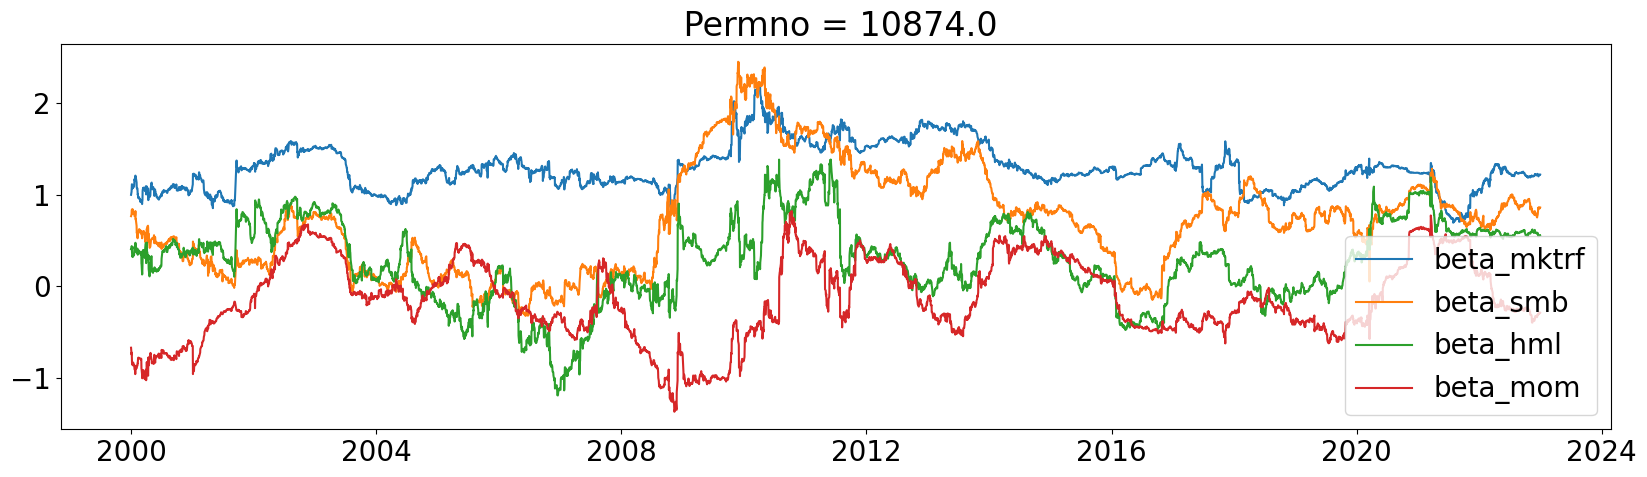

In [236]:
##### Sample graph for estimation of each day betas factors using rolling window regressions with a window of 252 trading days. {-}
permno_selection = crsp_sp500_betas_merged[crsp_sp500_betas_merged["permno"] == 10874.0]
plt.figure(figsize=(20,5))
plt.title(" Permno = 10874.0")
plt.plot(permno_selection["date"], permno_selection.iloc[:,-5:-1])
plt.legend(list(crsp_sp500_betas_merged.iloc[:,-5:-1].columns))
plt.show()

---
#### Merging crsp_sp500_betas_merged with the options data 



In [237]:
merged_crsp_options_df = pd.merge(crsp_sp500_betas_merged, option_metrics_data,  how = 'inner', left_on = ['date','permno'], right_on = ['date','permno'])
merged_crsp_options_df.head()

,permno,date,ret,mktcap,mom12m,mom6m,rev1m,beta_mktrf,beta_smb,beta_hml,beta_mom,idvar_ff4,secid,av_atmcall,av_otmput,av_otmcall,skew
0,10874.0,1999-12-31,-0.011111,2043.150750,-0.099618,-0.057281,0.031884,0.998254,0.764682,0.404181,-0.673465,0.149743,102386.0,0.391729,0.390299,0.393479,-0.001430
1,10874.0,2000-01-03,-0.014045,2014.454812,-0.109937,-0.080380,0.014451,1.032156,0.784538,0.414427,-0.746982,0.146484,102386.0,0.377306,0.383622,0.410990,0.006316
2,10874.0,2000-01-04,-0.045584,1922.627812,-0.107357,-0.099108,-0.026163,1.079493,0.830231,0.437168,-0.727018,0.147118,102386.0,0.381634,0.386107,0.390472,0.004473
3,10874.0,2000-01-05,0.005970,1934.106188,-0.112517,-0.115711,-0.017493,1.113169,0.829421,0.402571,-0.801960,0.146055,102386.0,0.384885,0.376034,0.371259,-0.008851
4,10874.0,2000-01-06,0.008902,1951.323750,-0.115097,-0.099960,0.017964,1.113622,0.839856,0.356142,-0.855652,0.144450,102386.0,0.386594,0.373572,0.394718,-0.013022


----
### 5 - Generalized lower bounds https://osf.io/7xcqwLinks to an external site. from https://dx.doi.org/10.2139/ssrn.3565130. Basicall Ready-to-use option-implied data. 


In [238]:
gen_lower_bounds = pd.read_csv(FileNames.gen_lower_bounds)
gen_lower_bounds = gen_lower_bounds[gen_lower_bounds.id.isin(permno_selection_list)]
gen_lower_bounds["date"] = pd.to_datetime(gen_lower_bounds["date"])
gen_lower_bounds.head()

In [240]:
# Merging with CRSP data with generalized lower bound data 
crsp500_lower_bound = pd.merge(merged_crsp_options_df, gen_lower_bounds,  how = 'left', left_on = ['date','permno'], right_on = ['date','id'])
crsp500_lower_bound = crsp500_lower_bound.drop(columns = "id")
crsp500_lower_bound.head()

,permno,date,ret,mktcap,mom12m,mom6m,rev1m,beta_mktrf,beta_smb,beta_hml,beta_mom,idvar_ff4,secid,av_atmcall,av_otmput,av_otmcall,skew,glb2_D30,glb3_D30,glb2_D91,glb3_D91,glb2_D182,glb3_D182,glb2_D273,glb3_D273,glb2_D365,glb3_D365
0,10874.0,1999-12-31,-0.011111,2043.150750,-0.099618,-0.057281,0.031884,0.998254,0.764682,0.404181,-0.673465,0.149743,102386.0,0.391729,0.390299,0.393479,-0.001430,0.020093,0.020091,0.021330,0.021328,NaN,NaN,NaN,NaN,NaN,NaN
1,10874.0,2000-01-03,-0.014045,2014.454812,-0.109937,-0.080380,0.014451,1.032156,0.784538,0.414427,-0.746982,0.146484,102386.0,0.377306,0.383622,0.410990,0.006316,0.019980,0.019978,0.021342,0.021340,NaN,NaN,NaN,NaN,NaN,NaN
2,10874.0,2000-01-04,-0.045584,1922.627812,-0.107357,-0.099108,-0.026163,1.079493,0.830231,0.437168,-0.727018,0.147118,102386.0,0.381634,0.386107,0.390472,0.004473,0.022905,0.022920,0.024641,0.024658,NaN,NaN,NaN,NaN,NaN,NaN
3,10874.0,2000-01-05,0.005970,1934.106188,-0.112517,-0.115711,-0.017493,1.113169,0.829421,0.402571,-0.801960,0.146055,102386.0,0.384885,0.376034,0.371259,-0.008851,0.022442,0.022457,0.024527,0.024544,NaN,NaN,NaN,NaN,NaN,NaN
4,10874.0,2000-01-06,0.008902,1951.323750,-0.115097,-0.099960,0.017964,1.113622,0.839856,0.356142,-0.855652,0.144450,102386.0,0.386594,0.373572,0.394718,-0.013022,0.022667,0.022683,0.025024,0.025042,NaN,NaN,NaN,NaN,NaN,NaN


----
### 6 - Risk-neutral skewness https://osf.io/btvdh/ from http://dx.doi.org/10.2139/ssrn.1301648 

In [357]:
risk_neutral_skewness = pd.read_csv(FileNames.risk_neutral_skewness)
risk_neutral_skewness = risk_neutral_skewness[risk_neutral_skewness.id.isin(permno_selection_list)]
risk_neutral_skewness["date"] = pd.to_datetime(risk_neutral_skewness["date"])
print(risk_neutral_skewness.shape)
risk_neutral_skewness.head(3)

(323338, 7)


,date,id,mfis30,mfis91,mfis182,mfis273,mfis365
21,1996-01-04,10874.0,-0.273181,-0.233504,NaN,NaN,NaN
29,1996-01-04,11308.0,-0.670556,-0.217849,-0.223627,-0.280642,-0.303623
32,1996-01-04,11404.0,1.010067,0.113864,0.118524,NaN,NaN


In [356]:
# Merging crsp500 data including the generalized lower bounds with the new variables risk skweness 
crsp500_risk_skewness = pd.merge(crsp500_lower_bound, risk_neutral_skewness, left_on = ["permno", "date"], right_on = ["id", "date"],  how='left')
crsp500_risk_skewness = crsp500_risk_skewness.drop(columns = ["id"])
crsp500_risk_skewness.head(3)

--- 
### 7 - Additional Features: (Technical Analysis, Sentiment, Price patterns, etc.)

#### Price Pattern Variables: 

##### 1. Lagged returns up to 21 days 
##### 2. Rolling weekly mean returns
##### 3. Rolling weekly std 

In [259]:
def compute_techincal_labels(df):
    
    cols2use = ['permno','date','ret']
    data0 = df.reset_index()[cols2use].copy()
    data0 = data0.sort_values(by = ['permno','date'])
    
    # Computing 1 day forward return 
    
    data0['fret1d'] = data0.groupby(by=['permno'])['ret'].shift(-1)

    # Calculating rolling weekly mean return 
    fn_mean2w = lambda x: x.rolling(window=10, min_periods=1).mean()
    
    # Calculating rolling weekly volatitly 
    fn_std2w = lambda x: x.rolling(window=10, min_periods=1).std()

    data0['mean2w'] = data0.groupby('permno')['fret1d'].apply(fn_mean2w)
    data0['std2w'] = data0.groupby('permno')['fret1d'].apply(fn_std2w)

    for lag in range(1,22): 
        data0["lag_"+ str(lag)] = data0.groupby(by=['permno'])['fret1d'].shift(lag)

    data0 = data0.drop(columns = ["ret"])

    return data0

In [260]:
technical_df = compute_techincal_labels(crsp500_risk_skewness)

In [261]:
print(list(technical_df.columns))

['permno', 'date', 'fret1d', 'mean2w', 'std2w', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21']


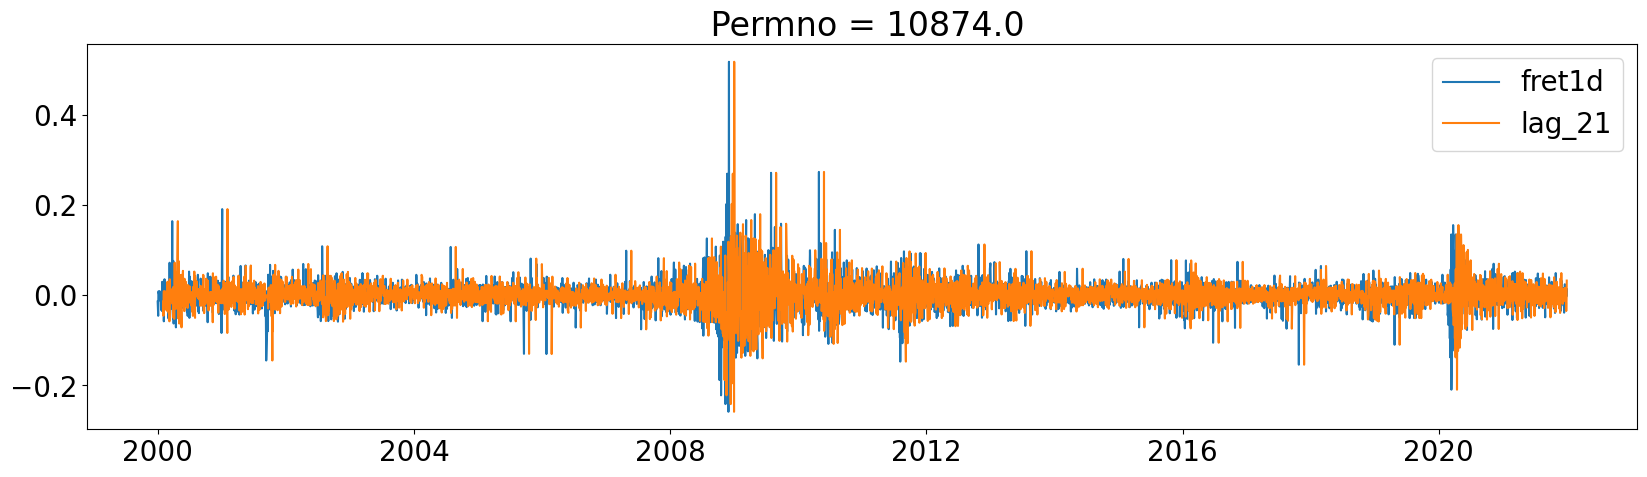

In [262]:
##### Sample graph for estimation of lagged values 
permno_selection = technical_df[technical_df["permno"] == 10874.0]
plt.figure(figsize=(20,5))
plt.title(" Permno = 10874.0")
plt.plot(permno_selection["date"], permno_selection.loc[:,["fret1d", "lag_21"]])
plt.legend(["fret1d", "lag_21"])
plt.show()

In [263]:
permno_selection.sort_values(by = "date", ascending = False)[["date","fret1d", "lag_1"]]

,date,fret1d,lag_1
5536,2021-12-31,NaN,0.013584
5535,2021-12-30,0.013584,-0.002910
5534,2021-12-29,-0.002910,0.014246
5533,2021-12-28,0.014246,0.007381
5532,2021-12-27,0.007381,0.007020
...,...,...,...
4,2000-01-06,0.005882,0.008902
3,2000-01-05,0.008902,0.005970
2,2000-01-04,0.005970,-0.045584
1,2000-01-03,-0.045584,-0.014045


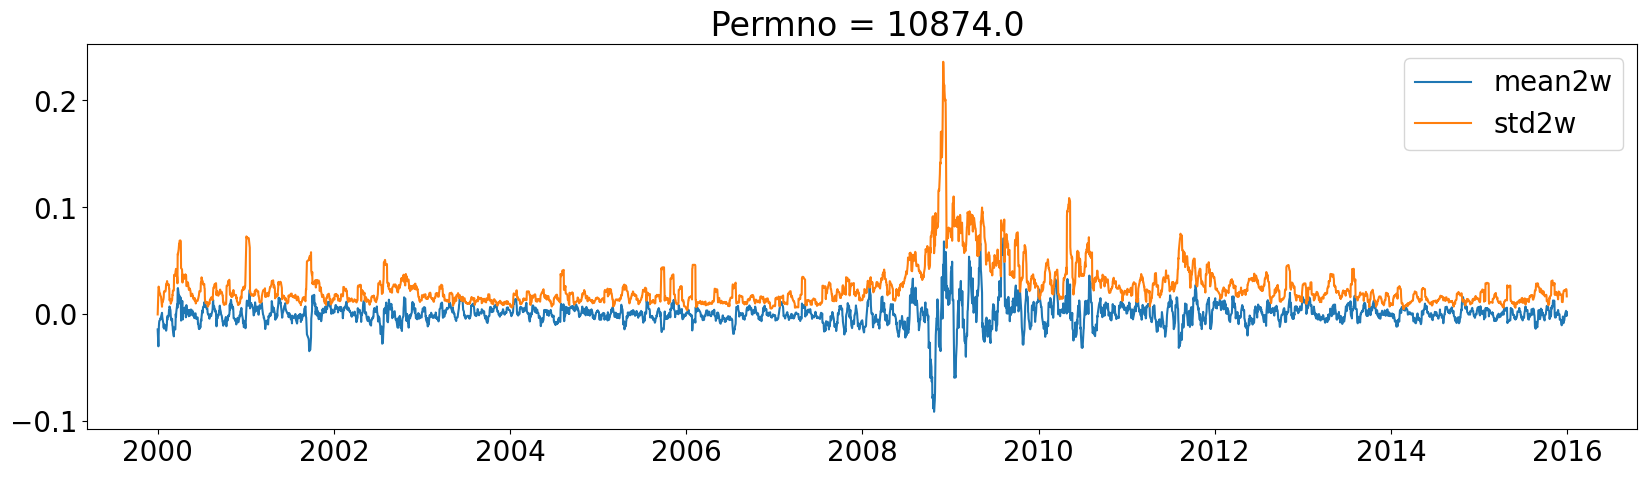

In [27]:
permno_selection = technical_df[technical_df["permno"] == 10874.0]
plt.figure(figsize=(20,5))
plt.title(" Permno = 10874.0")
plt.plot(permno_selection["date"], permno_selection.loc[:,["mean2w", "std2w"]])
plt.legend(["mean2w", "std2w"])
plt.show()

---
### Final Master Table Creation 

Includes the following datasets: 


In [359]:
master_table = pd.merge(crsp500_risk_skewness, technical_df, left_on = ["permno", "date"], right_on = ["permno", "date"],  how='left')
print(master_table.shape)
print("-------------------------")
master_table.columns

(276841, 57)
-------------------------


Index(['permno', 'date', 'ret', 'mktcap', 'mom12m', 'mom6m', 'rev1m',
       'beta_mktrf', 'beta_smb', 'beta_hml', 'beta_mom', 'idvar_ff4', 'secid',
       'av_atmcall', 'av_otmput', 'av_otmcall', 'skew', 'glb2_D30', 'glb3_D30',
       'glb2_D91', 'glb3_D91', 'glb2_D182', 'glb3_D182', 'glb2_D273',
       'glb3_D273', 'glb2_D365', 'glb3_D365', 'year', 'mfis30', 'mfis91',
       'mfis182', 'mfis273', 'mfis365', 'fret1d', 'mean2w', 'std2w', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9',
       'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16',
       'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21'],
      dtype='object')

In [361]:
master_table.to_csv("master_table_test.csv", index= False )

In [24]:
check = pd.read_csv("training_df.csv", index_col = [0])
check["date"] = pd.to_datetime(check["date"])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0dbfd423-fa3a-4cf9-b7ab-66e1f2070500' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>